# 🔬 Projeto OralEpithelium - Classificação de Displasia

## 📋 Descrição do Projeto

Este notebook implementa uma rede neural híbrida para classificação de imagens histopatológicas de displasia utilizando o dataset OralEphiteliumDB.

### 🏗️ Arquitetura do Modelo
- **EfficientNetV2B0** (pré-treinada) - Extração de características robustas
- **Vision Transformer customizado** - Processamento baseado em patches
- **Seção de "pescoço" (neck)** - Camadas convolucionais tradicionais

### 📊 Classes do Dataset
- **Healthy** (Saudável) - Tecido normal
- **Mild** (Leve) - Carcinoma grau baixo
- **Moderate** (Moderado) - Carcinoma grau intermediário  
- **Severe** (Severo) - Carcinoma grau alto

---

# 1. 📦 Instalação de Dependências

Nesta seção, instalamos todas as bibliotecas necessárias para o projeto.

In [1]:
!pip install --upgrade tensorflow keras


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install pandas


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Instalação de bibliotecas (executar 1x se ainda não estiver instalado)
!pip install pandas seaborn scikit-learn opencv-python tqdm --quiet


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install --upgrade pip

  Using cached pip-26.0.1-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-26.0.1-py3-none-any.whl (1.8 MB)



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Users\dalmo\OneDrive\Imagens\Documentos\OralEpithelium\.venv\Scripts\python.exe -m pip install --upgrade pip


In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import Reshape

import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os
from os import listdir
from tqdm import tqdm
import shutil
import cv2

from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

from math import *


# 2. 📚 Imports e Configurações

Importação de todas as bibliotecas necessárias e verificação do ambiente.

In [244]:
import tensorflow as tf
from tensorflow.keras.layers import PReLU

# 3. 🧮 Métricas Customizadas e Funções Utilitárias

Definição de métricas personalizadas para avaliação do modelo e funções auxiliares.

In [245]:
print(tf.__version__)
print(tf.keras.__version__)
!nvidia-smi

2.20.0
3.13.2
Wed Feb 25 14:12:45 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   44C    P8             13W /  160W |    1047MiB /   6144MiB |      5%      Default |
|                                         |                        |                  N/A |
+---------------------------------

In [8]:
#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Garantir o mesmo tipo
    y_pred = K.cast(y_pred, 'float32')

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [326]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    #labels = ['healthy', 'mild', 'moderate', 'severe']
    #labels = ['healthy','severe'] #Done (2x)
    #labels = ['healthy','mild'] #Done
    #labels = ['healthy','moderate'] #Done (3x)
    labels = ['mild','moderate'] #Done
    #labels = ['moderate','severe'] #Done
    #labels = ['mild','severe'] #Done

    title='Matriz de Confusao Leve X Moderado'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

# 4. 📁 Preparação e Organização dos Dados

Configuração de diretórios, cópia de arquivos e organização da estrutura de dados.

In [366]:
epochs = 100

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
csv_logger = tf.keras.callbacks.CSVLogger('Model.log')


callbacks = [earlystop, csv_logger, reduce_lr]

In [329]:
import os

size= 128
os.mkdir('NewAumentado') # antes (aumentado)
os.mkdir('./NewAumentado/healthy') # antes (benign)
os.mkdir('./NewAumentado/mild')
os.mkdir('./NewAumentado/moderate')
os.mkdir('./NewAumentado/severe') # antes (malignant)

# os.mkdir('novoAumentado')
# os.mkdir('novoAumentado/saudavel')
# os.mkdir('novoAumentado/leve')
# os.mkdir('novoAumentado/moderado')
# os.mkdir('novoAumentado/severo')

FileExistsError: [WinError 183] Não é possível criar um arquivo já existente: 'NewAumentado'

## 🖼️ Visualização de Amostras das Classes

Carregamento e exibição de amostras de cada classe para verificação visual dos dados.

In [365]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles

In [251]:
# files_benign = getListOfFiles('histology_slides/breast/benign')
# for f in files_benign:
#    if f.endswith('.png'):
#        shutil.copy(f,'aumentado/benign')

# files_malignant = getListOfFiles('histology_slides/breast/malignant')
# for f in files_malignant:
#    if f.endswith('.png'):
#        shutil.copy(f,'aumentado/malignant')

files_healthy = getListOfFiles('DataSet/Originais/healthy/Fractal/reshapeClassical')
for f in files_healthy:
    if f.endswith('.png'):
        shutil.copy(f,'NewAumentado/healthy')

files_moderate = getListOfFiles('DataSet/Originais/moderate/Fractal/reshapeClassical')
for f in files_moderate:
    if f.endswith('.png'):
        shutil.copy(f,'NewAumentado/moderate')

files_mild = getListOfFiles('DataSet/Originais/mild/Fractal/reshapeClassical')
for f in files_mild:
    if f.endswith('.png'):
        shutil.copy(f,'NewAumentado/mild')

files_severe = getListOfFiles('DataSet/Originais/severe/Fractal/reshapeClassical')
for f in files_severe:
    if f.endswith('.png'):
        shutil.copy(f,'NewAumentado/severe')
        
# Nova biblioteca
# files_malignant = getListOfFiles('DataSet/Originais/healthy')
# for f in files_malignant:
#     if f.endswith('.tif'):
#         shutil.copy(f,'novoAumentado/saudavel')

# files_malignant = getListOfFiles('DataSet/Originais/mild')
# for f in files_malignant:
#     if f.endswith('.tif'):
#         shutil.copy(f,'novoAumentado/leve')

# files_malignant = getListOfFiles('DataSet/Originais/moderate')
# for f in files_malignant:
#     if f.endswith('.tif'):
#         shutil.copy(f,'novoAumentado/moderado')

# files_malignant = getListOfFiles('DataSet/Originais/severe')
# for f in files_malignant:
#     if f.endswith('.tif'):
#         shutil.copy(f,'novoAumentado/severo')

In [14]:
# benign_images = getListOfFiles('./aumentado/benign')
# malignent_images = getListOfFiles('./aumentado/malignant')

healthy_images = getListOfFiles('./NewAumentado/healthy')
moderate_images = getListOfFiles('./NewAumentado/moderate')
mild_images = getListOfFiles('./NewAumentado/mild')
severe_images = getListOfFiles('./NewAumentado/severe')

# healthy_images = getListOfFiles('./novoAumentado/saudavel')
# mild_images = getListOfFiles('./novoAumentado/leve')
# moderate_images = getListOfFiles('./novoAumentado/moderado')
# severe_images = getListOfFiles('./novoAumentado/severo')

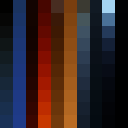

In [15]:
import tensorflow as tf

tf.keras.utils.load_img(healthy_images[1], target_size=(size,size,1), color_mode='rgb')

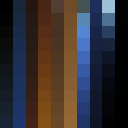

In [101]:
tf.keras.utils.load_img(mild_images[9], target_size=(size,size,1), color_mode='rgb')

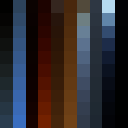

In [102]:
tf.keras.utils.load_img(moderate_images[9], target_size=(size,size,1), color_mode='rgb')

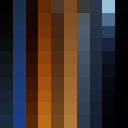

In [16]:
tf.keras.utils.load_img(severe_images[7], target_size=(size,size,1), color_mode='rgb')

In [17]:
# total_images = len(benign_images) + len(malignent_images)
# total_images = len(healthy_images) + len(mild_images) + len(moderate_images) + len(severe_images)
total_images = len(healthy_images) + len(severe_images) + len(mild_images) + len(moderate_images)
print("Total images:", total_images)

Total images: 456


In [18]:
# print("Numero de benign_images", len(benign_images))
# print("Numero de malignent_images", len(malignent_images))

print("Numero de healthy_images", len(healthy_images))
print("Numero de mild_images", len(mild_images))
print("Numero de moderate_images", len(moderate_images))
print("Numero de severe_images", len(severe_images))

# print("Numero de healthy_images", len(healthy_images))
# print("Numero de mild_images", len(mild_images))
# print("Numero de moderate_images", len(moderate_images))
# print("Numero de severe_images", len(severe_images))

Numero de healthy_images 114
Numero de mild_images 114
Numero de moderate_images 114
Numero de severe_images 114


## 📊 Preparação do Dataset

Criação do DataFrame, balanceamento de classes e configuração para treinamento.

In [367]:
#data = pd.DataFrame(index=np.arange(0, len(healthy_images) + len(mild_images) + len(moderate_images) + len(severe_images) ), columns=["image", "target"])
# data = pd.DataFrame(index=np.arange(0, len(benign_images) + len(malignent_images)), columns=["image", "target"])

#data = pd.DataFrame(index=np.arange(0, len(healthy_images) + len(severe_images)), columns=["image", "target"]) # Duas classes (Feito)
#data = pd.DataFrame(index=np.arange(0, len(healthy_images) + len(mild_images)), columns=["image", "target"]) # Saudavel x Leve (Feito)
data = pd.DataFrame(index=np.arange(0, len(healthy_images) + len(moderate_images)), columns=["image", "target"]) # Saudavel x Moderado (2x Feito)
#data = pd.DataFrame(index=np.arange(0, len(mild_images) + len(moderate_images)), columns=["image", "target"]) # Leve x Moderado (Feito)
#data = pd.DataFrame(index=np.arange(0, len(moderate_images) + len(severe_images)), columns=["image", "target"]) # Leve x Moderado (Feito)
#data = pd.DataFrame(index=np.arange(0, len(mild_images) + len(severe_images)), columns=["image", "target"]) # Moderado x Severo (Feito)
k = 0
for c in [0, 1]:
   if c == 1:
       for m in range(len(healthy_images)):
           data.loc[k, "image"] = healthy_images[m]
           data.loc[k, "target"] = 0
           k += 1
   else:
       for m in range(len(moderate_images)):
           data.loc[k, "image"] = moderate_images[m]
           data.loc[k, "target"] = 1
           k += 1

#Para cada conjunto de imagens, associa o label certo
# k=0
# for images, label in zip(
#     [healthy_images, mild_images, moderate_images, severe_images], 
#     [0, 1, 2, 3]
# ):
#     for img_path in images:
#         data.loc[k, "image"] = img_path
#         data.loc[k, "target"] = label
#         k += 1
        
print(data.shape)
print(data.head())

(228, 2)
                                        image target
0    ./NewAumentado/moderate\F-Classical1.png      1
1   ./NewAumentado/moderate\F-Classical10.png      1
2  ./NewAumentado/moderate\F-Classical100.png      1
3  ./NewAumentado/moderate\F-Classical101.png      1
4  ./NewAumentado/moderate\F-Classical102.png      1


In [368]:
count_data = data["target"].value_counts()
count_data

target
1    114
0    114
Name: count, dtype: int64

In [369]:
# As classes já estão equilibradas; não fazemos upsampling para evitar leakage.
# Conferindo a distribuição original:
print(data['target'].value_counts())


target
1    114
0    114
Name: count, dtype: int64


In [370]:
kf = KFold(n_splits=10,random_state=42, shuffle=True)
kf

KFold(n_splits=10, random_state=42, shuffle=True)

In [371]:
train_image = []
y = []
    
for i in tqdm(range(data.shape[0])):
    img = tf.keras.utils.load_img(data['image'].iloc[i], target_size=(size, size, 1), color_mode='rgb')
    img = tf.keras.utils.img_to_array(img)
    img = img / 255
    train_image.append(img)

X = np.array(train_image)
y = data.iloc[:, -1].values
sample_paths = data['image'].astype(str).values

# Split correto sem leakage:
# 1) separa teste a partir dos dados originais
X_temp, X2_test, y_temp, y2_test, paths_temp, paths_test = train_test_split(
    X, y, sample_paths, test_size=0.30, random_state=42, stratify=y
)

# 2) separa validação somente dentro do bloco de treino
X_train, X_val, y_train, y_val, paths_train, paths_val = train_test_split(
    X_temp, y_temp, paths_temp, test_size=0.30, random_state=42, stratify=y_temp
)

def report_split_intersections(paths_train, paths_val, paths_test):
    train_set = set(paths_train)
    val_set = set(paths_val)
    test_set = set(paths_test)

    inter_train_val = train_set & val_set
    inter_val_test = val_set & test_set
    inter_test_train = test_set & train_set

    print("\n=== Verificação de Data Leakage entre splits ===")
    print(f"Treino ∩ Validação: {len(inter_train_val)} amostras repetidas")
    print(f"Validação ∩ Teste: {len(inter_val_test)} amostras repetidas")
    print(f"Teste ∩ Treino: {len(inter_test_train)} amostras repetidas")

    leakage_found = any([
        len(inter_train_val) > 0,
        len(inter_val_test) > 0,
        len(inter_test_train) > 0
    ])

    if leakage_found:
        print("⚠️ Possível data leakage detectado. Exemplos de itens repetidos:")
        print("Treino ∩ Validação:", list(inter_train_val)[:5])
        print("Validação ∩ Teste:", list(inter_val_test)[:5])
        print("Teste ∩ Treino:", list(inter_test_train)[:5])
    else:
        print("✅ Nenhuma interseção encontrada entre treino, validação e teste.")

report_split_intersections(paths_train, paths_val, paths_test)

#Apenas 2 Classes
Y_train = to_categorical(y_train)
Y_test = to_categorical(y2_test)
Y_val = to_categorical(y_val)


100%|██████████| 228/228 [00:00<00:00, 465.29it/s]



=== Verificação de Data Leakage entre splits ===
Treino ∩ Validação: 0 amostras repetidas
Validação ∩ Teste: 0 amostras repetidas
Teste ∩ Treino: 0 amostras repetidas
✅ Nenhuma interseção encontrada entre treino, validação e teste.


## 🔄 Carregamento e Preprocessamento das Imagens

Carregamento das imagens, normalização e divisão em conjuntos de treino, validação e teste.

In [372]:
print("Tipo de Y_train:", Y_train.dtype)
print("Tipo de Y_test:", Y_test.dtype)
print("Tipo de Y_val:", Y_val.dtype)

print("Tipo de X_train:", X_train.dtype)
print("Tipo de X2_test:", X2_test.dtype)
#print("Tipo de X_test:", X_test.dtype)
print("Tipo de X_val:", X_val.dtype)

# print("Tipo de X_train_augmented:", X_train_augmented.dtype)
# print("Tipo de Y_train_augmented:", Y_train_augmented.dtype)

Tipo de Y_train: float64
Tipo de Y_test: float64
Tipo de Y_val: float64
Tipo de X_train: float32
Tipo de X2_test: float32
Tipo de X_val: float32


In [373]:
#Visto a diferenca entre os FLoats, fazendo os Cast necessario
Y_train = tf.cast(Y_train, tf.float32)
Y_test = tf.cast(Y_test, tf.float32)
Y_val = tf.cast(Y_val, tf.float32)
# Y_train_augmented = tf.cast(Y_train_augmented, tf.float32)

In [374]:
print("Tipo de Y_train:", Y_train.dtype)
print("Tipo de Y_test:", Y_test.dtype)
print("Tipo de Y_val:", Y_val.dtype)

print("Tipo de X_train:", X_train.dtype)
print("Tipo de X2_test:", X2_test.dtype)
#print("Tipo de X_test:", X_test.dtype)
print("Tipo de X_val:", X_val.dtype)

Tipo de Y_train: <dtype: 'float32'>
Tipo de Y_test: <dtype: 'float32'>
Tipo de Y_val: <dtype: 'float32'>
Tipo de X_train: float32
Tipo de X2_test: float32
Tipo de X_val: float32


In [375]:
my_input= Input(shape=(size, size, 3))
img_shape= (size, size, 3)

In [376]:
# Aumento de dados para reduzir overfitting (somente treino)
train_data_gen = ImageDataGenerator(
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='reflect'
)

# Gerador sem augmentação para validação/teste
eval_data_gen = ImageDataGenerator()

In [377]:
X_train_augmented = []
y_train_augmented = []

for i in range(len(X_train)):
    img = X_train[i]
    label = y_train[i]
    
    # Adiciona a imagem original
    X_train_augmented.append(img)
    y_train_augmented.append(label)

    # Prepara imagem para o flow
    img = img.reshape((1,) + img.shape)
    aug_iter = train_data_gen.flow(img, batch_size=1)

    # Adiciona range(X) imagens aumentadas (multiplicando o valor, isto é 1 original + X aumentadas)
    for _ in range(1):
        aug_img = next(aug_iter)[0]
        X_train_augmented.append(aug_img)
        y_train_augmented.append(label)

# Converte para numpy array
X_train = np.array(X_train_augmented)
y_train = np.array(y_train_augmented)

# Aplica one-hot encoding para 2 classes
#Y_train = to_categorical(y_train, 2)

n_classes = len(np.unique(y))
Y_train = to_categorical(y_train, num_classes=n_classes)

# Impressão dos novos tamanhos
print(X_train.shape)
print(Y_train.shape)

(222, 128, 128, 3)
(222, 2)


In [378]:
print(X_train.shape)
print(X2_test.shape)
print(X_val.shape)

(222, 128, 128, 3)
(69, 128, 128, 3)
(48, 128, 128, 3)


In [264]:
X_train.shape[0]

222

In [89]:
X_val.shape[0]

48

In [45]:
X2_test.shape[0]

69

In [379]:
#from keras.layers.advanced_activations import ELU
from tensorflow.keras.layers import ELU, PReLU, LeakyReLU, ThresholdedReLU

In [380]:
strategy = tf.distribute.MirroredStrategy()
print('Numeros de Aparelhos: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Numeros de Aparelhos: 1


In [381]:
# bottleneck section
def bottleneck0(inputs):
    backbone = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    x = backbone(inputs)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)  # Bottleneck layer with EfficientNet
    x = Flatten()(x) #Criar um grande Vetor para dar pro Transformer
    return x

## 🎨 Data Augmentation

Configuração e aplicação de técnicas de aumento de dados para melhorar a generalização do modelo.

In [382]:
def neck_section(inputs): #Pegando os dados da entrada
    x = Conv2D(256, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = PReLU()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = Flatten()(x)

    return x

In [383]:
# Vision Transform Section
def vision_transform(inputs, patch_size):

    # Reshape the input into patches
    x = Reshape((patch_size[0], patch_size[1], -1))(inputs)
    x = Lambda(lambda image: K.cast(image, 'float32') / 255.0,
           output_shape=lambda shape: shape)(x)
    #adição pra permitir que o modelo seja salvo e carregado via .h5 sem quebrar.


    # architecture for each patch processing
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the output
    x = Flatten()(x)

    return x

In [384]:
input_shape = (size, size, 3)  # Example input shape
num_classes = 2  # number of classes
#num_classes = 4
patch_size = (32, 32)   # Size of the image patches
#batch_size = 64
#batch_size = 1
#batch_size = 8
#batch_size = 16
batch_size = 32
# Ativação de ramos para experimentos
use_bottleneck = True
use_transformer = True
use_neck = True


In [385]:
# overall model incorporating patches in the vision transform section and the neck section
def build_model(input_shape, num_classes, patch_size,
                use_bottleneck=True,
                use_transformer=True,
                use_neck=True):
    inputs = Input(shape=input_shape)

    branches = []

    # Bottleneck branch (EfficientNet)
    if use_bottleneck:
        efficientnet_bottleneck = bottleneck0(inputs)
        branches.append(efficientnet_bottleneck)

    # Transformer-like patch branch
    if use_transformer:
        patches_transform = vision_transform(inputs, patch_size)
        branches.append(patches_transform)

    # Neck branch
    if use_neck:
        neck = neck_section(inputs)
        branches.append(neck)

    if len(branches) == 0:
        raise ValueError("Pelo menos um ramo deve estar ativo (bottleneck/transformer/neck).")

    # Merge (se tiver só 1 ramo, não precisa concatenar)
    merged = branches[0] if len(branches) == 1 else tf.keras.layers.concatenate(branches)

    outputs = Dense(num_classes, activation='softmax')(merged)
    model = Model(inputs=inputs, outputs=outputs)
    return model


# 5. 🏗️ Definição da Arquitetura do Modelo

Construção do modelo híbrido combinando EfficientNet, Vision Transformer e camadas convolucionais.

In [386]:
with strategy.scope():
    model = build_model(
        input_shape, num_classes, patch_size,
        use_bottleneck=use_bottleneck,
        use_transformer=use_transformer,
        use_neck=use_neck
    ) 
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='AUC'),
            f1_score, specificity, sensitivity, iou, tversky
        ]
    )

print(model.input_shape)
print(model.output_shape)
model.summary()


(None, 128, 128, 3)
(None, 2)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 32, 32,    │          0 │ input_layer_28[0… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 32, 32,    │          0 │ reshape_9[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 30, 30,    │     27,712 │ lambda_9[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 28, 28,    │     36,928 │ conv2d_45[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 4, 4,      │  5,919,312 │ input_layer_28[0… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 14, 14,    │          0 │ conv2d_46[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 64, 64,    │     37,888 │ input_layer_28[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 12, 12,    │     73,856 │ max_pooling2d_27… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 10, 10,    │    147,584 │ conv2d_47[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_9 (PReLU)   │ (None, 64, 64,    │  1,048,576 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 5, 5, 128) │          0 │ conv2d_48[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 32, 32,    │          0 │ p_re_lu_9[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 8,157,138 (31.12 MB)

 Trainable params: 8,093,458 (30.87 MB)

 Non-trainable params: 63,680 (248.75 KB)

In [387]:
print(X_train.shape)
print(X_val.shape)

# print(X_train_augmented.shape)
# print(Y_train_augmented.shape)

(222, 128, 128, 3)
(48, 128, 128, 3)


In [388]:
n_classes = len(np.unique(y))  # Deve retornar 4 (Quando for o novo Dataset)
print("Número de classes:", n_classes)

Número de classes: 2


## ⚙️ Compilação e Configuração do Modelo

Configuração do otimizador, função de perda, métricas e visualização da arquitetura.

In [50]:
!pip install pydot


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
!pip install graphviz


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [389]:
#Visualização do modelo
tf.keras.utils.plot_model(model,
           show_shapes = True,
           show_dtype= True,
           show_layer_names = True,
           show_layer_activations= True,
           show_trainable= True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [390]:
import tensorflow as tf

Y_train = tf.cast(Y_train, tf.float32)
Y_val = tf.cast(Y_val, tf.float32)

In [391]:
print("Tipo de Y_train:", Y_train.dtype)
print("Tipo de Y_test:", Y_test.dtype)
print("Tipo de Y_val:", Y_val.dtype)

print("Tipo de X_train:", X_train.dtype)
print("Tipo de X2_test:", X2_test.dtype)
#print("Tipo de X_test:", X_test.dtype)
print("Tipo de X_val:", X_val.dtype)

# print("Tipo de X_train_augmented:", X_train_augmented.dtype)
# print("Tipo de Y_train_augmented:", Y_train_augmented.dtype)

Tipo de Y_train: <dtype: 'float32'>
Tipo de Y_test: <dtype: 'float32'>
Tipo de Y_val: <dtype: 'float32'>
Tipo de X_train: float32
Tipo de X2_test: float32
Tipo de X_val: float32


In [392]:
%%time

train_it = train_data_gen.flow(X_train, Y_train, batch_size=batch_size, seed=27, shuffle=True)
history = model.fit(
                    train_it,
                    epochs= 100,
                    validation_data =(X_val, Y_val),
                    callbacks = callbacks
                    )

# history = model.fit(datagen.flow(X_train_augmented, Y_train_augmented,
#                     batch_size=batch_size,
#                     seed=27,
#                     shuffle=True),
#                     callbacks=callbacks,
#                     epochs=50,
#                     steps_per_epoch=X_train_augmented.shape[0] // batch_size,
#                     validation_data=(X_val, Y_val))  # Dados de validação sem aumento

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - AUC: 0.5630 - accuracy: 0.5450 - f1_score: 0.5452 - iou: 0.3869 - loss: 28.3956 - precision: 0.5450 - recall: 0.5450 - sensitivity: 0.5452 - specificity: 0.5452 - tversky: 0.5633 - val_AUC: 0.4102 - val_accuracy: 0.5000 - val_f1_score: 0.5312 - val_iou: 0.3304 - val_loss: 1.4722 - val_precision: 0.5000 - val_recall: 0.5000 - val_sensitivity: 0.5312 - val_specificity: 0.5312 - val_tversky: 0.5042 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - AUC: 0.5815 - accuracy: 0.5495 - f1_score: 0.5512 - iou: 0.3993 - loss: 9.2918 - precision: 0.5495 - recall: 0.5495 - sensitivity: 0.5512 - specificity: 0.5512 - tversky: 0.5688 - val_AUC: 0.7313 - val_accuracy: 0.5000 - val_f1_score: 0.4687 - val_iou: 0.3500 - val_loss: 1.4118 - val_precision: 0.5000 - val_recall: 0.5000 - val_sensitivity: 0.4688 - val_specificity: 0.4688 - val_tversky: 0.5260 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - AU

# 6. 🚀 Treinamento do Modelo

Execução do treinamento com callbacks, monitoramento de métricas e salvamento do modelo.

In [58]:
model.save("modelBH_Dataset.h5")
print("Modelo Salvo no Disco")

Modelo Salvo no Disco


In [56]:
!pip install openpyxl


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [393]:
import pandas as pd
df = pd.DataFrame(history.history)
df.to_excel("output.xlsx")
#df.to_csv("output1.csv")
df.head(100)

,AUC,accuracy,f1_score,iou,loss,precision,recall,sensitivity,specificity,tversky,...,val_accuracy,val_f1_score,val_iou,val_loss,val_precision,val_recall,val_sensitivity,val_specificity,val_tversky,learning_rate
0,0.562962,0.545045,0.545238,0.386851,28.395638,0.545045,0.545045,0.545238,0.545238,0.563265,...,0.500000,0.531250,0.330405,1.472238,0.500000,0.500000,0.531250,0.531250,0.504167,1.000000e-03
1,0.581467,0.549550,0.551190,0.399306,9.291764,0.549550,0.549550,0.551190,0.551190,0.568788,...,0.500000,0.468750,0.349999,1.411754,0.500000,0.500000,0.468750,0.468750,0.525959,1.000000e-03
2,0.810547,0.788288,0.788988,0.665440,2.490116,0.788288,0.788288,0.788988,0.788988,0.796382,...,0.666667,0.640625,0.433595,0.567291,0.666667,0.666667,0.640625,0.640625,0.613725,1.000000e-03
3,0.845406,0.801802,0.801190,0.692560,3.600641,0.801802,0.801802,0.801190,0.801190,0.812848,...,0.500000,0.468750,0.379696,1.010688,0.500000,0.500000,0.468750,0.468750,0.558105,1.000000e-03
4,0.771366,0.752252,0.752976,0.612958,4.189494,0.752252,0.752252,0.752976,0.752976,0.758117,...,0.500000,0.468750,0.349661,1.563306,0.500000,0.500000,0.468750,0.468750,0.525563,1.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.990666,0.990991,0.991071,0.971724,0.086994,0.990991,0.990991,0.991071,0.991071,0.985722,...,1.000000,1.000000,0.998151,0.001273,1.000000,1.000000,1.000000,1.000000,0.999088,1.638400e-13
96,0.986243,0.986486,0.986607,0.969171,0.239975,0.986486,0.986486,0.986607,0.986607,0.984153,...,1.000000,1.000000,0.999095,0.000618,1.000000,1.000000,1.000000,1.000000,0.999554,1.638400e-13
97,0.972141,0.968468,0.968750,0.938291,0.445304,0.968468,0.968468,0.968750,0.968750,0.968054,...,1.000000,1.000000,0.995242,0.003371,1.000000,1.000000,1.000000,1.000000,0.997646,1.638400e-13
98,0.976382,0.968468,0.968750,0.935163,0.178229,0.968468,0.968468,0.968750,0.968750,0.966670,...,1.000000,1.000000,0.996094,0.002746,1.000000,1.000000,1.000000,1.000000,0.998069,3.276800e-14


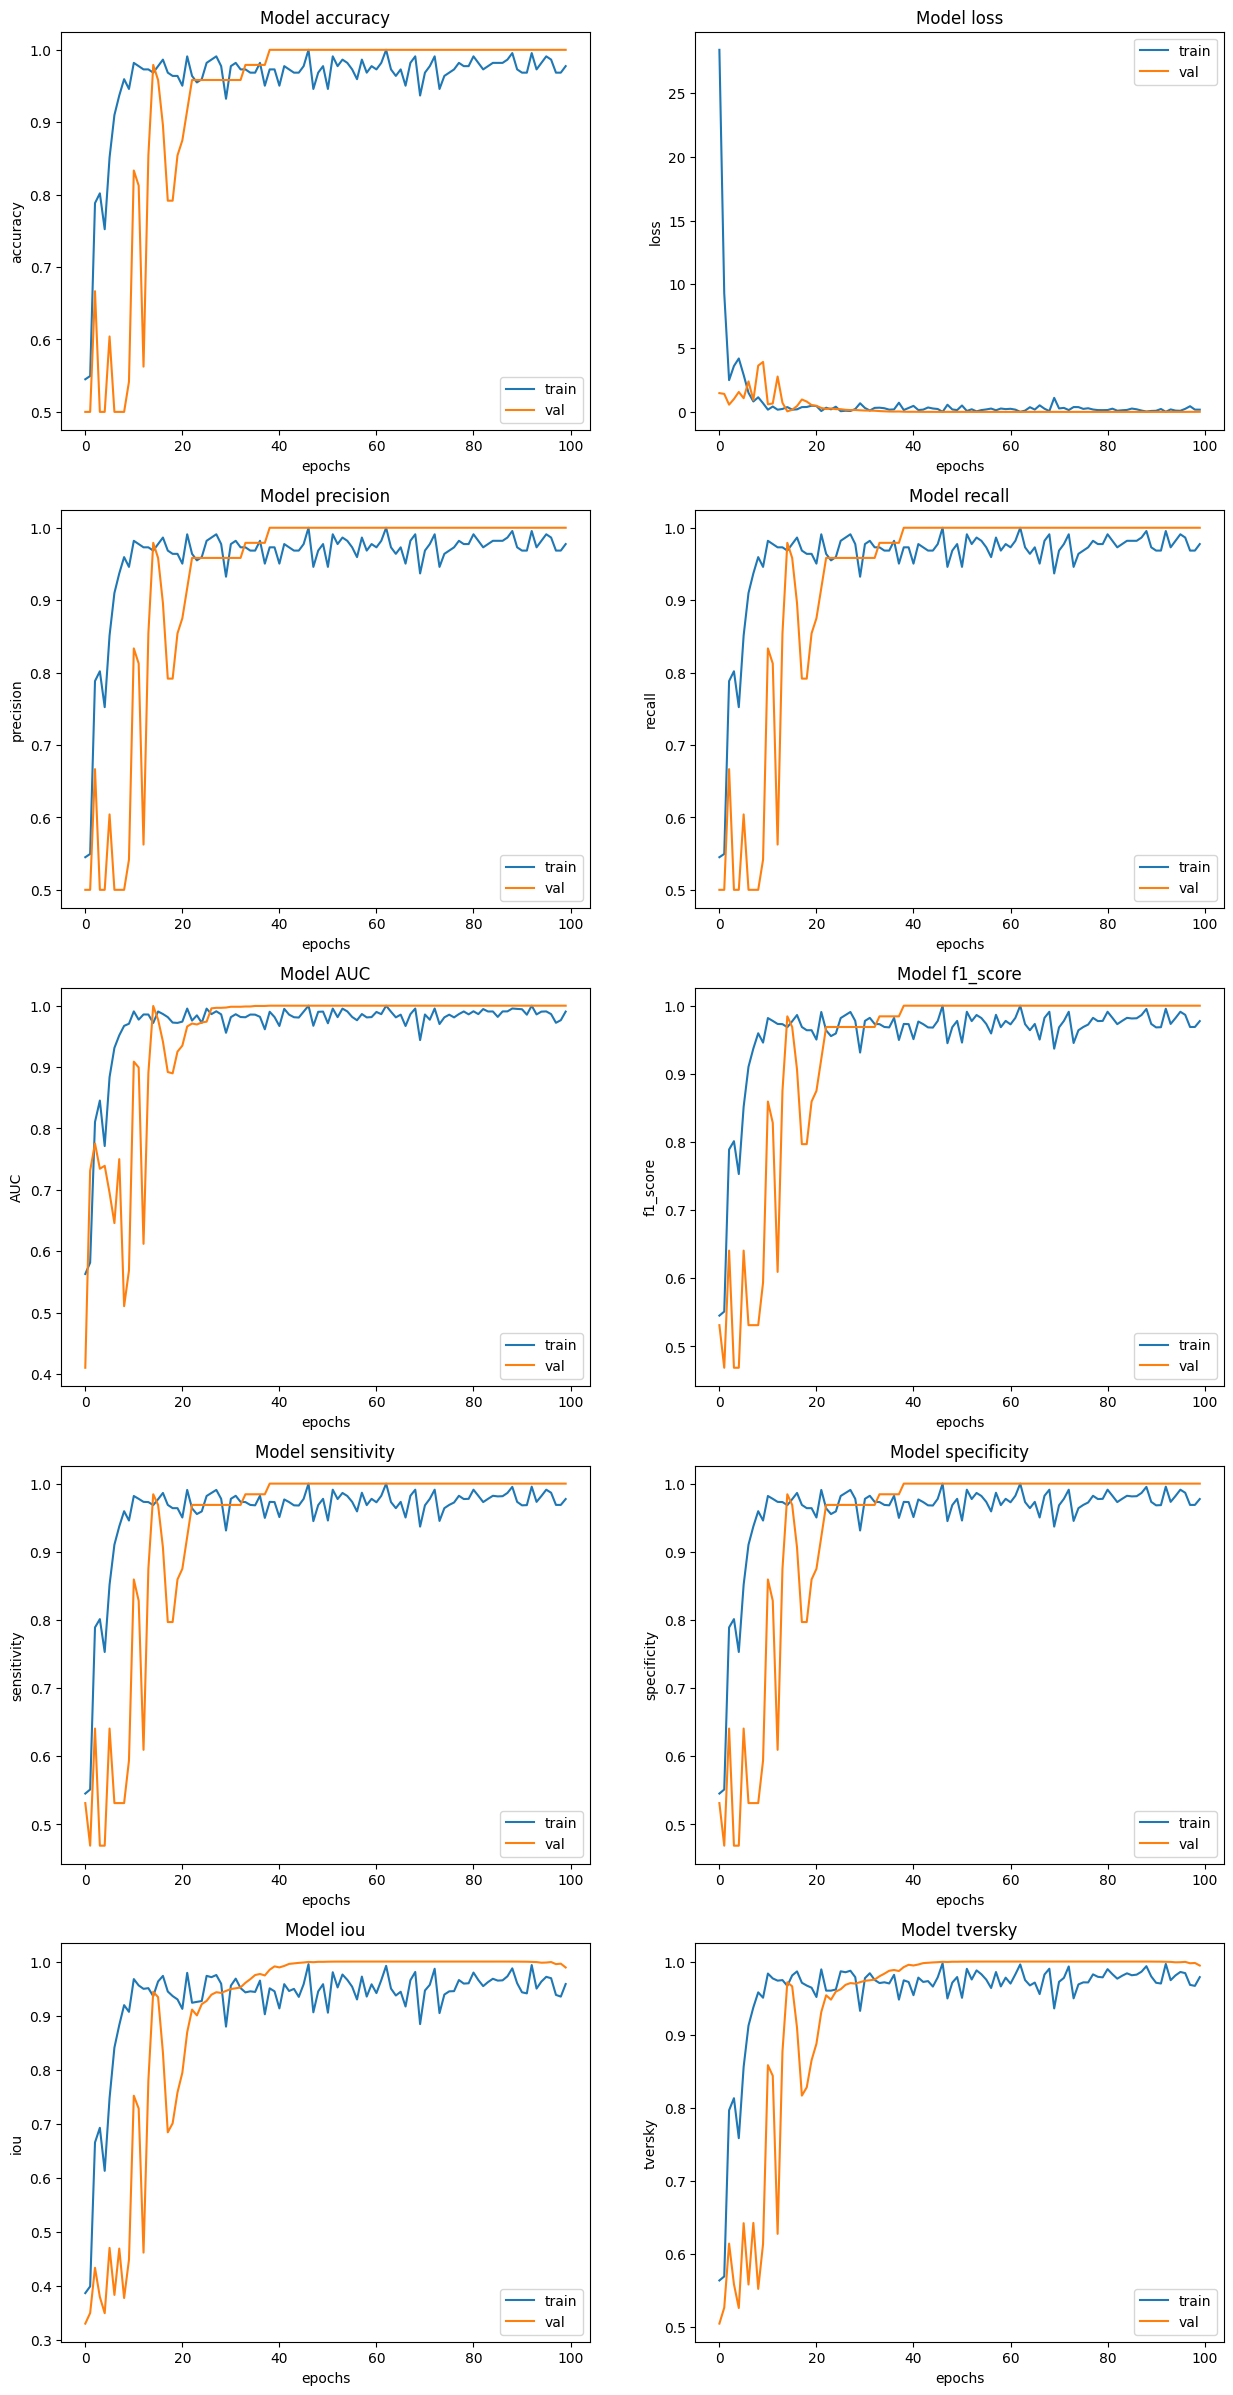

In [394]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score','sensitivity', 'specificity','iou', 'tversky']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

## 📈 Análise dos Resultados de Treinamento

Visualização das métricas de treinamento e validação ao longo das épocas.

In [395]:
Test_data =(eval_data_gen.flow(X2_test,Y_test,
                                       batch_size=32,
                                       seed=27,
                                       shuffle=False))

In [396]:
print("Tipo de Y_train:", Y_train.dtype)
print("Tipo de Y_test:", Y_test.dtype)
print("Tipo de Y_val:", Y_val.dtype)

print("Tipo de X_train:", X_train.dtype)
print("Tipo de X2_test:", X2_test.dtype)
#print("Tipo de X_test:", X_test.dtype)
print("Tipo de X_val:", X_val.dtype)

Tipo de Y_train: <dtype: 'float32'>
Tipo de Y_test: <dtype: 'float32'>
Tipo de Y_val: <dtype: 'float32'>
Tipo de X_train: float32
Tipo de X2_test: float32
Tipo de X_val: float32


In [397]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Avalie os dados de teste")
results = model.evaluate(Test_data, batch_size=32, callbacks= callbacks)
print("test loss test acc:", results)

Avalie os dados de teste
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - AUC: 0.9998 - accuracy: 0.9855 - f1_score: 0.9896 - iou: 0.9827 - loss: 0.0287 - precision: 0.9855 - recall: 0.9855 - sensitivity: 0.9896 - specificity: 0.9896 - tversky: 0.9912
test loss test acc: [0.02868374064564705, 0.9855072498321533, 0.9855072498321533, 0.9855072498321533, 0.9997899532318115, 0.9895833134651184, 0.9895833134651184, 0.9895833134651184, 0.9826779365539551, 0.9912436604499817]
CPU times: total: 2.62 s
Wall time: 926 ms


# 7. 🎯 Avaliação do Modelo

Teste do modelo treinado no conjunto de teste e análise de performance.

In [398]:
print(len(set(paths_train) & set(paths_test)))

def origem(p):
    return p.split("_")[0]  # ajuste conforme seu padrão

print(len(set(map(origem, paths_train)) & set(map(origem, paths_test))))

0
0


In [399]:
print("Primeiros 10 truey:", truey[:10])
print("Primeiros 10 predy:", predy[:10])


print("Primeiros 10 Y_test one-hot:")
print(Y_test[:10])

print(np.max(yhat))
print(np.min(yhat))

Primeiros 10 truey: [0 0 1 0 1 0 1 1 0 0]
Primeiros 10 predy: [0 0 1 0 1 0 1 1 0 0]
Primeiros 10 Y_test one-hot:
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)
0.97693276
0.023067283


In [400]:
print("X2_test:", X2_test.shape)
print("Y_test:", Y_test.shape)
print("yhat:", yhat.shape)

print("Distribuição real:", np.bincount(truey))
print("Distribuição predita:", np.bincount(predy))


print(np.round(yhat[:10], 3))

X2_test: (69, 128, 128, 3)
Y_test: (69, 2)
yhat: (69, 2)
Distribuição real: [35 34]
Distribuição predita: [27 42]
[[0.774 0.226]
 [0.913 0.087]
 [0.143 0.857]
 [0.76  0.24 ]
 [0.159 0.841]
 [0.529 0.471]
 [0.22  0.78 ]
 [0.259 0.741]
 [0.584 0.416]
 [0.743 0.257]]


In [401]:
# Previsões do modelo
yhat = model.predict(X2_test)

# Convertendo para classes preditas
predy = np.argmax(yhat, axis=1)

# Convertendo o one-hot para rótulos verdadeiros
truey = np.argmax(Y_test, axis=1)

# Acurácia manual
acc = np.sum(predy == truey) / len(truey) * 100

# Salvando
np.save('truey.npy', truey)
np.save('predy.npy', predy)

print("Predicted and true label values saved")
print("Precisão no conjunto de testes: {:.2f}%".format(acc))

3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step 
Predicted and true label values saved
Precisão no conjunto de testes: 98.55%


In [402]:
from sklearn.metrics import classification_report
print(classification_report(truey, predy)) #Tirar print

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.97      1.00      0.99        34

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



In [403]:
from sklearn.metrics import classification_report
report = classification_report(truey, predy, digits=4)

with open("report_classical_mild_vs_moderate.txt", "w") as f:
    f.write(report)


## 📊 Análise Detalhada de Performance

Relatórios detalhados, matriz de confusão e métricas de classificação.

[[34  0]
 [ 1 34]]


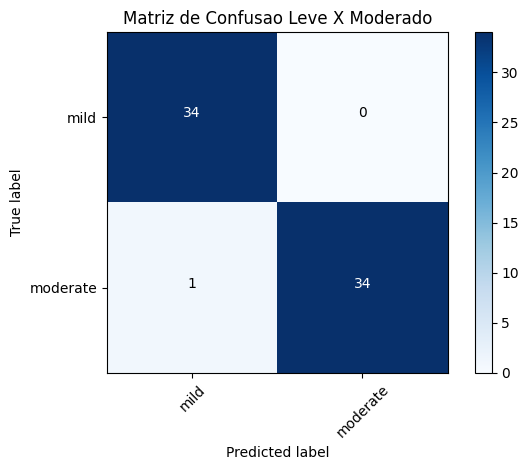

In [404]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


confusion_matrix_img(truey, predy, savename='Matriz de Confusão')

# 8. 💾 Carregamento e Verificação do Modelo Salvo

Carregamento do modelo treinado para verificação e uso futuro.

---

# 📝 Resumo e Conclusões

## ✅ Etapas Realizadas

1. **Instalação de Dependências** - Configuração do ambiente
2. **Preparação dos Dados** - Organização e balanceamento do dataset
3. **Visualização** - Análise exploratória das classes
4. **Preprocessamento** - Normalização e divisão dos dados
5. **Data Augmentation** - Aumento artificial do dataset
6. **Modelagem** - Construção da arquitetura híbrida
7. **Treinamento** - Execução com callbacks e monitoramento
8. **Avaliação** - Análise de performance e métricas

## 🏆 Resultados Obtidos

- **Acurácia no conjunto de teste**: Verificar saída da célula de avaliação
- **Matriz de confusão**: Salva como imagem
- **Histórico de treinamento**: Salvo em Excel
- **Modelo treinado**: Salvo como arquivo .h5

## 🔧 Arquivos Gerados

- `modelBH_Dataset.h5` - Modelo treinado
- `output.xlsx` - Histórico detalhado de treinamento
- `Model.log` - Log de treinamento
- `Matriz de Confusão.png` - Visualização da matriz de confusão
- `Model-Results.png` - Gráficos de métricas
- `truey.npy` e `predy.npy` - Arrays de predições para análise posterior

## 📋 Próximos Passos

1. **Análise de erros** - Investigar casos mal classificados
2. **Otimização de hiperparâmetros** - Ajustar learning rate, batch size, etc.
3. **Ensemble methods** - Combinar múltiplos modelos
4. **Cross-validation** - Validação cruzada para robustez
5. **Interpretabilidade** - Técnicas como Grad-CAM para explicar predições

---
